In [ ]:
import torch
from easy_yolo_ocr.yolov5.models.yolo import Model
import matplotlib.pyplot as plt
from other.plots import *

/Users/kimelfeld/Desktop/Git Projects/ITMO/CV/Example-of-solving-a-CV-problem/easy_yolo_ocr/yolov5/utils/general.py:27: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg


In [2]:
cfg_path = "easy_yolo_ocr/yolov5/models/yolov5s.yaml"

model = Model(cfg=cfg_path, ch=3, nc=4)

weights = torch.load("easy_yolo_ocr/yolov5/runs/train/exp12/weights/best.pt", map_location='cpu', weights_only=False)

if 'model' in weights:
    state_dict = weights['model'].float().state_dict()
    
model.load_state_dict(state_dict)
model.eval()

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]             

Model(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3(
      (cv1): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv3): C

In [31]:
import cv2
from easy_yolo_ocr.yolov5.utils.general import non_max_suppression
import pandas as pd
from torchvision import transforms


def to_model(img, model):
  img_tensor = torch.from_numpy(img).float() / 255.0  # [H, W, C], нормализация
  img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)  # [1, 3, H, W]
  #transforms.Resize(320,320)
  #img_tensor = img_tensor
  model.eval()
  with torch.no_grad():
    pred = model(img_tensor)[0]
    pred = non_max_suppression(pred, conf_thres=0.4, iou_thres=0.45)
  return [{ name:value for value, name in zip(det, ('x','y','x2','y2','p','c'))} for det in pred[0]]


# 805 / 815
image_path = 'data/image808.jpg'
img = cv2.imread(image_path)  # загружаем в BGR (OpenCV-формат)
sub_images = []
array = []

for detect_obj in to_model(img, model):
  x, y,  x2, y2, p, class_id = detect_obj.values()
  if p < 0.6:
    continue
  sub_images.append(img[ int(y):int(y2) , int(x):int(x2)])
  array.append(detect_obj)


array.sort(key = lambda x: int(x['x']) )
df = pd.DataFrame(array)
df = pd.concat([ df[['x','y','x2','y2','c']].astype(int), df['p'].astype(float).round(2) ], axis=1)

In [32]:
df

,x,y,x2,y2,c,p
0,33,413,49,431,2,0.84
1,70,412,135,433,0,0.84
2,103,438,143,462,0,0.77
3,142,413,204,431,0,0.80
4,151,438,202,460,0,0.87
5,197,629,296,679,3,0.95
6,210,437,262,460,0,0.73
7,418,624,509,672,3,0.87


In [33]:
cls_names = {0 : 'name', 1:'price', 2:'count', 3 : 'total'}

In [34]:
import pandas as pd
import numpy as np
from collections import defaultdict

def group_receipt_items(df, y_tolerance=5):
    """
    Группирует прямоугольники сущностей чека по строкам.

    Параметры:
    - df: DataFrame с колонками ['id', 'x1', 'y1', 'x2', 'y2'] (координаты прямоугольников)
    - y_tolerance: допустимое отклонение по оси Y для объединения в строку (в пикселях)

    Возвращает:
    - Список групп (каждая группа - это строка чека), где каждая группа содержит индексы df
    """

    # Вычисляем вертикальные центры каждого прямоугольника
    df['y_center'] = (df['y'] + df['y2']) / 2

    # Сортируем все прямоугольники по вертикали (сверху вниз)
    df_sorted = df.sort_values('y_center').reset_index(drop=True)

    # Группируем по строкам (если вертикальные центры близки в пределах y_tolerance)
    groups = []
    current_group = [0]  # начинаем с первого элемента

    for i in range(1, len(df_sorted)):
        # Если текущий прямоугольник близок к предыдущему по вертикали
        if abs(df_sorted.loc[i, 'y_center'] - df_sorted.loc[i-1, 'y_center']) <= y_tolerance:
            current_group.append(i)
        else:
            # Добавляем завершенную группу и начинаем новую
            groups.append(current_group)
            current_group = [i]

    # Добавляем последнюю группу
    if current_group:
        groups.append(current_group)

    # Сортируем элементы внутри каждой группы по горизонтали (слева направо)
    for i in range(len(groups)):
        group_indices = groups[i]
        # Сортируем по x1 (левый край прямоугольника)
        sorted_indices = df_sorted.loc[group_indices].sort_values('x').index.tolist()
        groups[i] = sorted_indices

    # Возвращаем оригинальные индексы (из исходного df)
    result = []
    for group in groups:
        original_indices = df_sorted.loc[group, 'index'].tolist()
        result.append(original_indices)

    return result

In [35]:
groups = group_receipt_items(df.reset_index())

print(groups)

[[0, 1, 3], [2, 4, 6], [7], [5]]


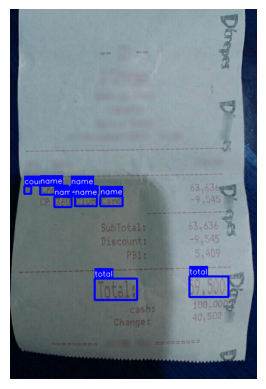

In [36]:
%matplotlib inline

for _, row in df.iterrows():
    label = cls_names[row.c]

    box = [row.x, row.y, row.x2, row.y2]

    plot_one_box(box,img,label=label,color=(0,0,255))

plt.imshow(img)
plt.axis('off')
plt.show()

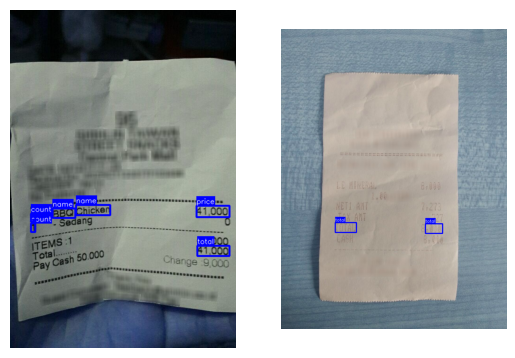

In [ ]:
_, axes = plt.subplots(ncols=2,nrows=1)
i=0

# 805 810

#
for img_num in range(805, 807):
     
    img_path = 'data/image'+str(img_num) + '.jpg'

    img = cv2.imread(img_path) 
  
    sub_images = []

    array = []

    for detect_obj in to_model(img, model):
        x, y,  x2, y2, p, class_id = detect_obj.values()
        if p < 0.6:
            continue
        sub_images.append(img[ int(y):int(y2) , int(x):int(x2)])
        array.append(detect_obj)
        array.sort(key = lambda x: int(x['x']) )
        df = pd.DataFrame(array)
        df = pd.concat([ df[['x','y','x2','y2','c']].astype(int), df['p'].astype(float).round(2) ], axis=1)
        for _, row in df.iterrows():
            label = cls_names[row.c]
            box = [row.x, row.y, row.x2, row.y2]
            plot_one_box(box,img,label=label,color=(0,0,255))

    axes[i].imshow(img)
    axes[i].axis('off')
    i+=1